In [1]:
TRIPS_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/NYC_Pilot2_PM_Part1.csv'
POLYGON_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/nyc_polygon.geojson'

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import h3

In [3]:
h3_resolution_min = 0
h3_resolution_max = 15
sampling_frequency = 0.6

In [4]:
def calculate_rmse(predicted_values, actual_values):
    # Calculate squared differences
    squared_diff = (predicted_values - actual_values) ** 2
    
    # Calculate mean squared differences
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse

In [5]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [6]:
population_pm25 = (trips
                .groupby('neighborhood')
                .pm25
                .agg(list)
                .to_frame("pm25_list")
                .reset_index())  # Make a list of pm25 values for each neighborhood

population_pm25['average_pm25_value'] = population_pm25['pm25_list'].apply(lambda x: sum(x) / len(x))  # Find the average pm25 value per neighborhood
population_pm25.drop('pm25_list', axis = 1, inplace=True)

population_pm25.sort_values(by='neighborhood', inplace=True)
population_pm25.reset_index(drop=True, inplace=True)

In [7]:
def group_by_h3(df, h3_resolution):
    df['h3'] = df.apply(lambda x: h3.geo_to_h3(x.latitude, x.longitude, resolution=h3_resolution), axis=1)
    return df.groupby('h3')

In [8]:
def perform_test():
    error = []
    h3_resolution = h3_resolution_min
    while h3_resolution <= h3_resolution_max:
        stratified_sample = group_by_h3(trips, h3_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
        random_sample_pm25 = (stratified_sample
                    .groupby('neighborhood')
                    .pm25
                    .agg(list)
                    .to_frame("pm25_list")
                    .reset_index())  # Make a list of pm25 values for each neighborhood
        random_sample_pm25['average_pm25_value'] = random_sample_pm25['pm25_list'].apply(lambda x: sum(x) / len(x))  # Find the average pm25 value per neighborhood
        random_sample_pm25.drop('pm25_list', axis = 1, inplace=True)
        for neighborhood in population_pm25["neighborhood"]:
            if neighborhood not in random_sample_pm25["neighborhood"].values:
                random_sample_pm25.loc[len(random_sample_pm25.index)] = [neighborhood, 0]
        random_sample_pm25.sort_values(by='neighborhood', inplace=True)
        random_sample_pm25.reset_index(drop=True, inplace=True)
        assert population_pm25['neighborhood'].equals(random_sample_pm25['neighborhood'])
        baseline_pm25 =    population_pm25["average_pm25_value"].values
        sampled_pm25  = random_sample_pm25["average_pm25_value"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse)
        h3_resolution += 1
    H3_Performance = pd.DataFrame({'H3 Resolution':list(range(h3_resolution_min, h3_resolution_max + 1)),
                                'RMSE': error})
    plt.figure()
    ax = H3_Performance.plot(kind='bar', x='H3 Resolution', y= 'RMSE')
    ax.bar_label(ax.containers[0], color = 'black')
    plt.show()

<Figure size 640x480 with 0 Axes>

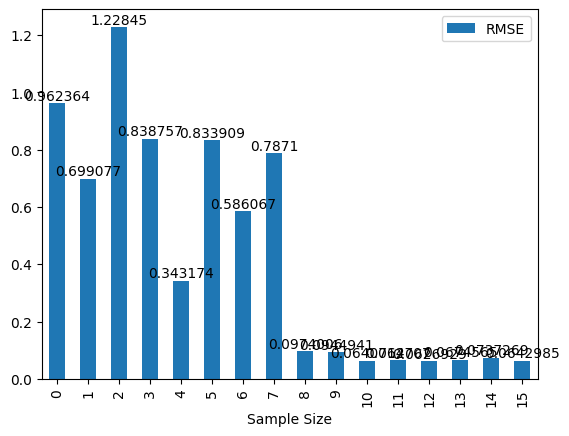

<Figure size 640x480 with 0 Axes>

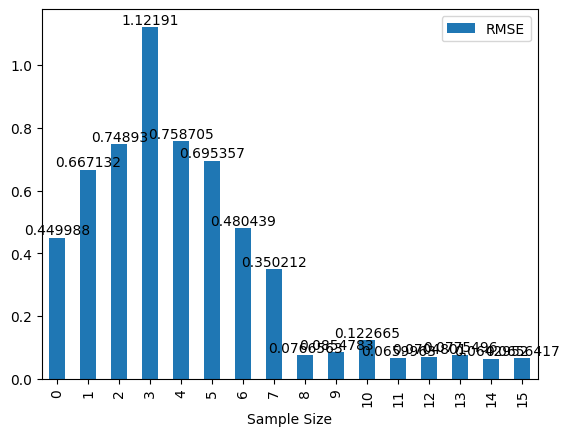

<Figure size 640x480 with 0 Axes>

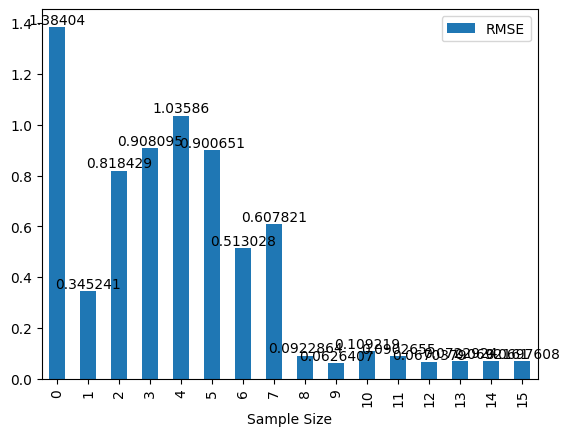

<Figure size 640x480 with 0 Axes>

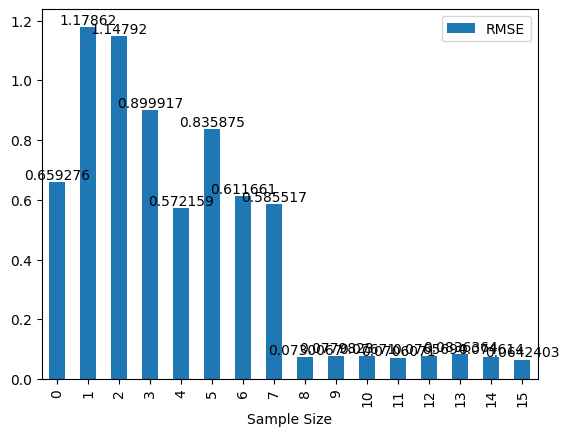

<Figure size 640x480 with 0 Axes>

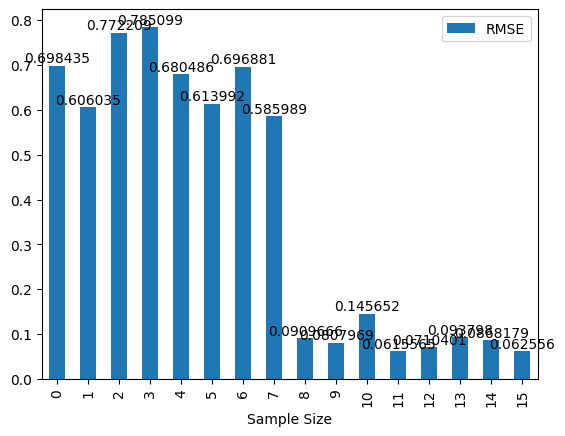

In [9]:
for _ in range(5):
    perform_test()

We see that with H3 resolutions >= 8, 60% is a good sample size to use for stratified sampling using H3 when it comes to reducing the dataset size while still retaining the same information on a neighborhood-level.